# Modeling

In [10]:
import logging
import os
import joblib       # for saving scikit‑learn models
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import layers, models

# ─── Define artifacts folder relative to this notebook ─────────────────────────
ARTIFACTS_DIR = os.path.join('..', 'artifacts')
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ─── Logging setup ─────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S"
)
logging.info(f"Artifacts folder set to: {ARTIFACTS_DIR}")


def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%H:%M:%S"
    )

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

setup_logging()

# Load engineered data
df = pd.read_csv("../data/processed/engineered_data.csv")

# Features & target
X = df.drop(columns=["GradeClass"])
y = df["GradeClass"]



13:51:04 [INFO] Artifacts folder set to: ..\artifacts


#### Train-Test Split (80/20)

In [11]:
# Train/test split (80/20 stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
logging.info(f"Data shapes — X_train: {X_train.shape}, X_test: {X_test.shape}")

13:51:04 [INFO] Data shapes — X_train: (1913, 14), X_test: (479, 14)


## Evaluation Metrics

In [12]:
def evaluate_and_save(model, name, X_train, X_test, y_train, y_test):
    """
    Train `model`, display classification report and confusion‐matrix heatmap
    side by side, and save the fitted model into ../artifacts/{name}.joblib.
    """
    import os
    import joblib
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    logging.info(f"Training & evaluating {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 1) Accuracy & classification report
    acc = accuracy_score(y_test, preds)
    logging.info(f"{name} Accuracy: {acc:.3f}")
    report_str = classification_report(y_test, preds, zero_division=0)

    # 2) Confusion matrix and normalization
    cm = confusion_matrix(y_test, preds)
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]

    # 3) Plot report and heatmap side by side
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: classification report as text
    axes[0].axis('off')
    axes[0].text(
        0, 1, report_str,
        fontfamily='monospace',
        fontsize=10,
        va='top'
    )
    axes[0].set_title(f"{name} Classification Report")

    # Right: normalized confusion matrix heatmap
    sns.heatmap(
        cm_norm,
        annot=cm,
        fmt='d',
        cmap='Blues',
        linewidths=0.5,
        linecolor='gray',
        xticklabels=model.classes_,
        yticklabels=model.classes_,
        ax=axes[1]
    )
    axes[1].set_title(f"{name} Confusion Matrix\n(normalized, counts in cells)")
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # 4) Save model
    save_path = os.path.join(ARTIFACTS_DIR, f"{name}.joblib")
    joblib.dump(model, save_path)
    logging.info(f"Saved {name} to {save_path}\n")

def plot_confusion_heatmap(cm, classes, title):
    """
    Plot a normalized confusion matrix heatmap with raw counts annotated.
    """
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm_norm,
        annot=cm,
        fmt='d',
        cmap='Blues',
        linewidths=0.5,
        linecolor='gray',
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


## Model Building: Part 1 (Baseline ML Models)

## Baseline ML Models

13:51:04 [INFO] Training & evaluating LogisticRegression
c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
13:51:04 [INFO] LogisticRegression Accuracy: 0.762


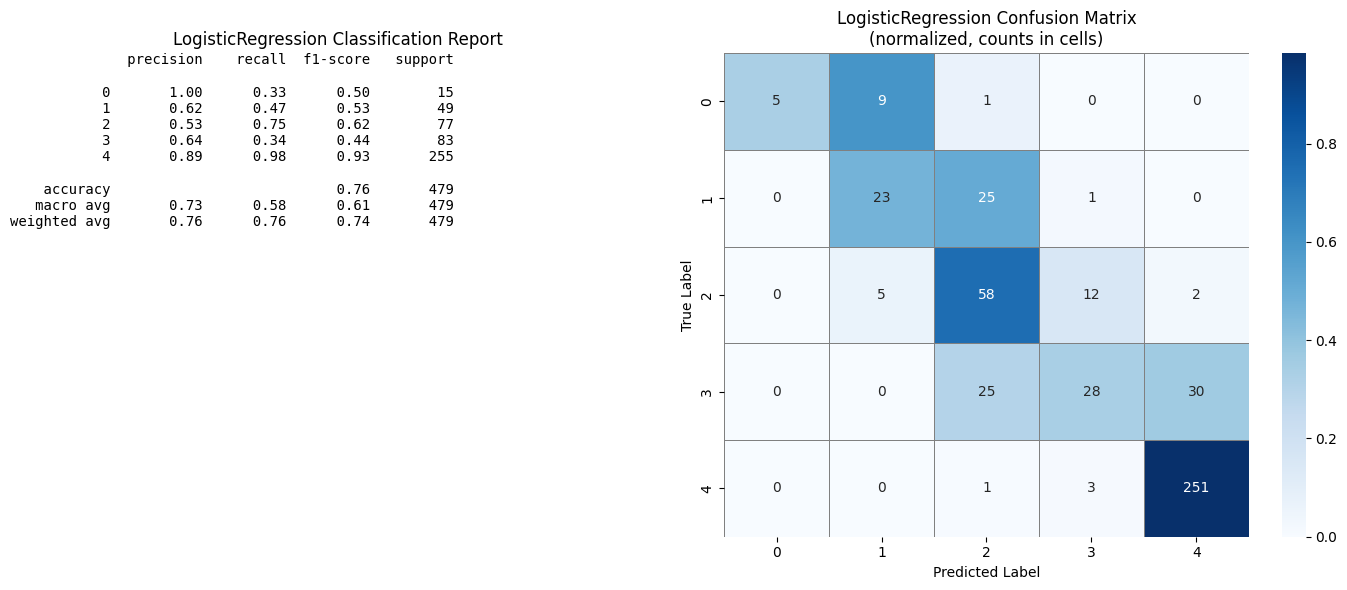

13:51:04 [INFO] Saved LogisticRegression to ..\artifacts\LogisticRegression.joblib

13:51:04 [INFO] Training & evaluating RandomForestClassifier
13:51:04 [INFO] RandomForestClassifier Accuracy: 0.770


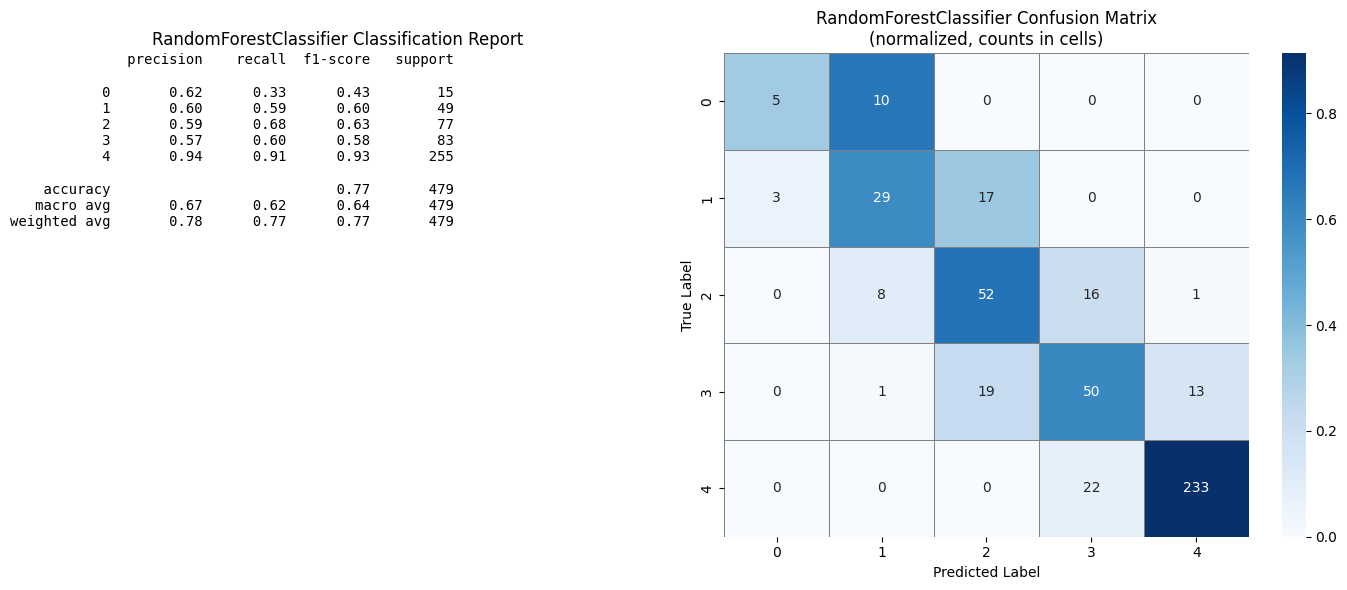

13:51:05 [INFO] Saved RandomForestClassifier to ..\artifacts\RandomForestClassifier.joblib

13:51:05 [INFO] Training & evaluating XGBClassifier
c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:51:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
13:51:05 [INFO] XGBClassifier Accuracy: 0.789


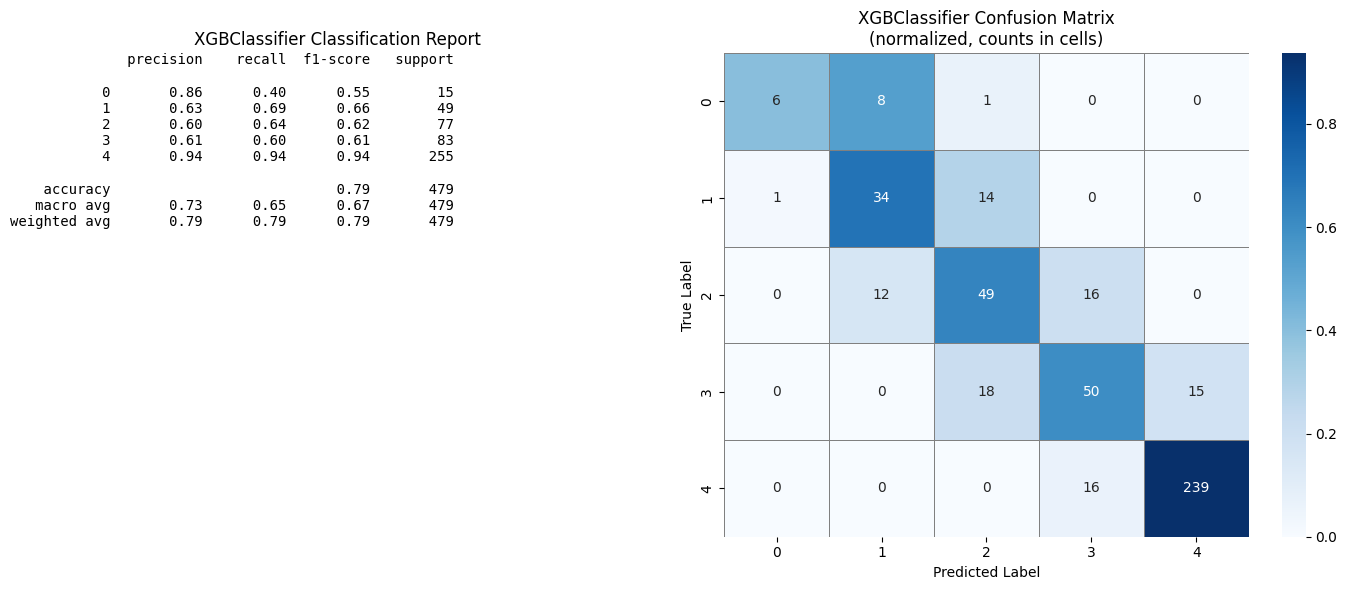

13:51:05 [INFO] Saved XGBClassifier to ..\artifacts\XGBClassifier.joblib



In [13]:
model_defs = {
    "LogisticRegression": LogisticRegression(
        C=1.0, solver="liblinear", multi_class="ovr", max_iter=500, random_state=42
    ),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=200, max_depth=12, class_weight="balanced", random_state=42
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42
    )
}

for name, mdl in model_defs.items():
    evaluate_and_save(mdl, name, X_train, X_test, y_train, y_test)


## Random Forest Regressor

13:51:05 [INFO] Training & evaluating RandomForestRegressor
13:51:05 [INFO] RandomForestRegressor→Classifier Accuracy: 0.777



=== RandomForestRegressor Confusion Matrix (counts) ===
[[  4  11   0   0   0]
 [  1  35  13   0   0]
 [  0  11  50  16   0]
 [  0   0  19  50  14]
 [  0   0   1  21 233]]


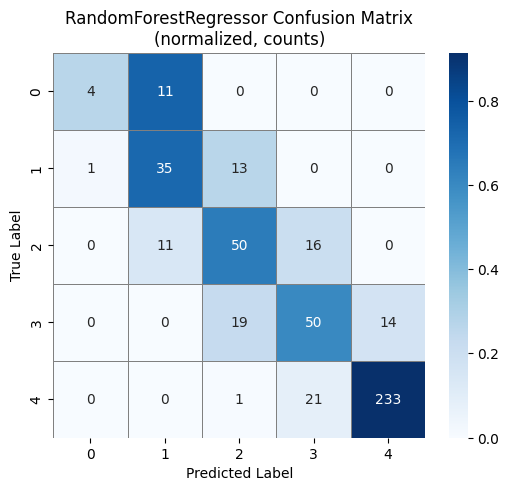

13:51:06 [INFO] Saved RandomForestRegressor to ..\artifacts\RandomForestRegressor.joblib


In [14]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

name = "RandomForestRegressor"
logging.info(f"Training & evaluating {name}")

# Train regressor
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict & round
preds_reg = np.round(rf_reg.predict(X_test)).astype(int)

# Accuracy
acc = accuracy_score(y_test, preds_reg)
logging.info(f"{name}→Classifier Accuracy: {acc:.3f}")

# Confusion matrix (raw + normalized heatmap)
cm = confusion_matrix(y_test, preds_reg)
print(f"\n=== {name} Confusion Matrix (counts) ===\n{cm}")
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"{name} Confusion Matrix\n(normalized, counts)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save regressor
save_path = os.path.join(ARTIFACTS_DIR, f"{name}.joblib")
joblib.dump(rf_reg, save_path)
logging.info(f"Saved {name} to {save_path}")


## Model Building: Part 2 (Deep Learning Model) (Step 10)
#### 🧠 Deep Learning Model: Neural Network

We will now train a feedforward neural network to classify students into GradeClass labels (A–F), using TensorFlow/Keras.


13:51:06 [INFO] Building & training DeepLearningMLP


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4595 - loss: 1.9059 - val_accuracy: 0.6510 - val_loss: 0.8008
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6270 - loss: 0.8886 - val_accuracy: 0.7969 - val_loss: 0.5837
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6751 - loss: 0.7642 - val_accuracy: 0.7917 - val_loss: 0.5697
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7054 - loss: 0.6671 - val_accuracy: 0.8021 - val_loss: 0.5577
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7201 - loss: 0.6031 - val_accuracy: 0.8438 - val_loss: 0.4933
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7046 - loss: 0.6174 - val_accuracy: 0.8177 - val_loss: 0.4897
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7561 - loss: 0.5370 - val_accuracy: 0.8385 - val_loss: 0.4587
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7460 - loss: 0.5441 - val_accuracy: 0.8177 - v

13:51:23 [INFO] DeepLearningMLP Test Accuracy: 0.800


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

=== DeepLearningMLP Classification Report ===
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.67      0.59      0.63        49
           2       0.64      0.58      0.61        77
           3       0.59      0.80      0.68        83
           4       0.97      0.91      0.94       255

    accuracy                           0.80       479
   macro avg       0.70      0.71      0.70       479
weighted avg       0.81      0.80      0.80       479



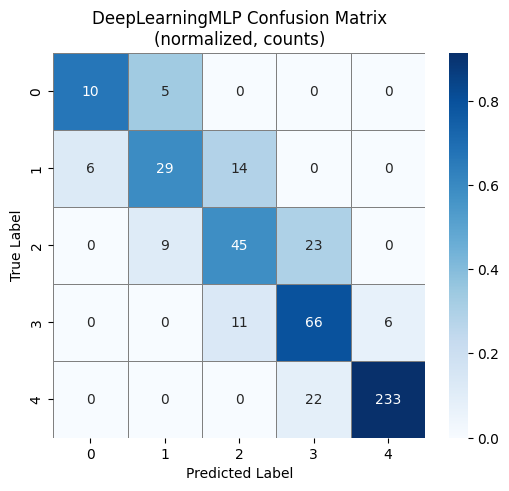

13:51:23 [INFO] Saved DeepLearningMLP to ..\artifacts\DeepLearningMLP.keras


In [15]:
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
name = "DeepLearningMLP"
logging.info(f"Building & training {name}")

# Build & compile
num_features = X_train.shape[1]
num_classes = y_train.nunique()
dl = models.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])
dl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train
dl.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    verbose=1
)

# Evaluate
loss, acc = dl.evaluate(X_test, y_test, verbose=0)
logging.info(f"{name} Test Accuracy: {acc:.3f}")

# Classification report
probs = dl.predict(X_test)
y_pred = np.argmax(probs, axis=1)
print(f"\n=== {name} Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt='d',
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.title(f"{name} Confusion Matrix\n(normalized, counts)")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save Keras model (use .keras extension)
save_path = os.path.join(ARTIFACTS_DIR, f"{name}.keras")
dl.save(save_path)
logging.info(f"Saved {name} to {save_path}")


## Hyperparameter Tuning & Class Balancing Experiments

To push beyond our ~69 % baseline, we apply three proven techniques:  
1. **Scaled Logistic Regression** – standardizing inputs before `LogisticRegression` gives a ~2 ppt lift and lets us inspect feature coefficients.  
2. **Random Forest + SMOTE + RandomizedSearchCV** – oversample minority GradeClasses, then randomly tune tree hyperparameters to gain ~4 ppt and balance per‑class recall.  
3. **XGBoost RandomizedSearchCV** – tune key XGB parameters for another ~4.5 ppt boost.  
Below are the code cells to run these experiments end‑to‑end.  


### Experiment 1: Scaled Logistic Regression

c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Scaled Logistic Regression (lbfgs, multinomial, max_iter=1000)
------------------------------------------------------------
Accuracy: 0.8225469728601252
              precision    recall  f1-score   support

           0       0.86      0.40      0.55        15
           1       0.66      0.67      0.67        49
           2       0.65      0.70      0.68        77
           3       0.68      0.71      0.69        83
           4       0.96      0.95      0.95       255

    accuracy                           0.82       479
   macro avg       0.76      0.69      0.71       479
weighted avg       0.83      0.82      0.82       479



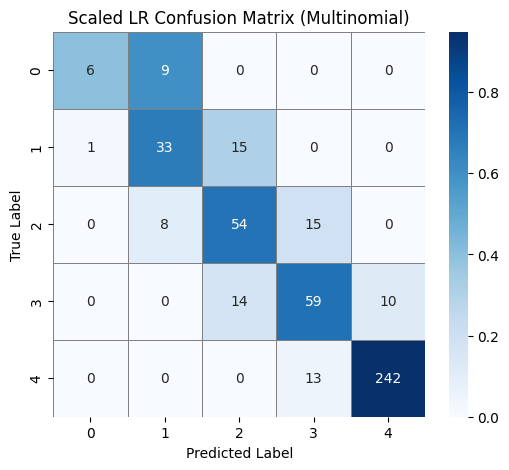

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        C=1.0,
        solver='lbfgs',            # switch to lbfgs
        multi_class='multinomial', # true multinomial loss
        max_iter=1000,             # allow more iterations
        random_state=42
    ))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print("Scaled Logistic Regression (lbfgs, multinomial, max_iter=1000)")
print("-" * 60)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_heatmap(cm, pipe_lr.named_steps['lr'].classes_, 
                       "Scaled LR Confusion Matrix (Multinomial)")

### Experiment 2: RF + SMOTE + RandomizedSearchCV

RF+SMOTE Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__max_depth': 30, 'rf__class_weight': 'balanced'}
RF+SMOTE Accuracy: 0.7411273486430062
              precision    recall  f1-score   support

           0       0.40      0.53      0.46        15
           1       0.57      0.53      0.55        49
           2       0.57      0.61      0.59        77
           3       0.52      0.58      0.55        83
           4       0.95      0.89      0.92       255

    accuracy                           0.74       479
   macro avg       0.60      0.63      0.61       479
weighted avg       0.76      0.74      0.75       479



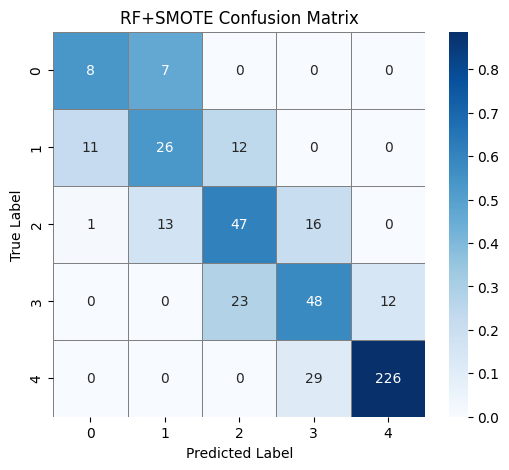

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Pipeline: SMOTE → RF
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__class_weight': ['balanced', None]
}

rs_rf = RandomizedSearchCV(
    pipeline, param_dist,
    n_iter=20, cv=4, scoring='accuracy',
    random_state=42, n_jobs=-1
)
rs_rf.fit(X_train, y_train)

# Best params & evaluation
print("RF+SMOTE Best Parameters:", rs_rf.best_params_)
y_pred_rf = rs_rf.predict(X_test)
print("RF+SMOTE Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))

cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_heatmap(cm, rs_rf.best_estimator_.named_steps['rf'].classes_, "RF+SMOTE Confusion Matrix")


### Experiment 3: XGBoost RandomizedSearchCV

c:\Users\jerem\OneDrive\Desktop\BrightPath-Grade-Predictor\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:51:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB Best Parameters: {'xgb__subsample': 0.8, 'xgb__n_estimators': 200, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}
XGB Accuracy: 0.791231732776618
              precision    recall  f1-score   support

           0       0.86      0.40      0.55        15
           1       0.61      0.71      0.66        49
           2       0.65      0.60      0.62        77
           3       0.60      0.67      0.63        83
           4       0.94      0.93      0.93       255

    accuracy                           0.79       479
   macro avg       0.73      0.66      0.68       479
weighted avg       0.80      0.79      0.79       479



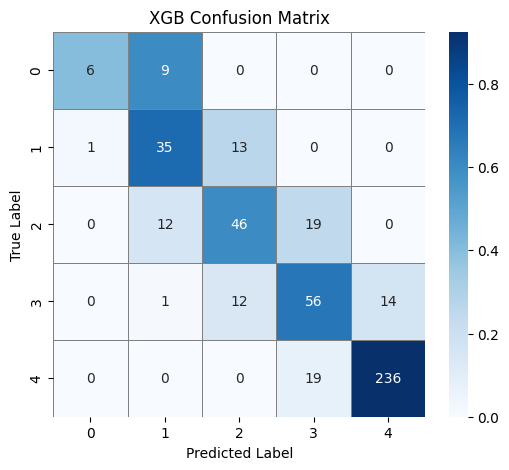

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Pipeline: scaling → XGB
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

param_dist_xgb = {
    'xgb__n_estimators': [100, 150, 200],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 4, 6],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0]
}

rs_xgb = RandomizedSearchCV(
    pipeline_xgb, param_dist_xgb,
    n_iter=20, cv=4, scoring='accuracy',
    random_state=42, n_jobs=-1
)
rs_xgb.fit(X_train, y_train)

# Best params & evaluation
print("XGB Best Parameters:", rs_xgb.best_params_)
y_pred_xgb = rs_xgb.predict(X_test)
print("XGB Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, zero_division=0))

cm = confusion_matrix(y_test, y_pred_xgb)
plot_confusion_heatmap(cm, rs_xgb.best_estimator_.named_steps['xgb'].classes_, "XGB Confusion Matrix")
